# <center> Training Pre-Trained Resnet18
## <center> To Classify Duck & Chicken Images

#### Importing Requisite packages

In [1]:
import os, sys, random, time, copy
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image

#### Setting directories

In [2]:
data_folder = "../data/cnn_data/"
cl_names = os.listdir(data_folder)

##### Checking if Cuda is available

In [3]:
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

Using GPU:  True


##### Setting the frequency of printing training stats

In [4]:
freq_print = 25

##### Loading data file paths (400 each for Chicken and Duck images)

In [5]:
def load_paths_from_folder(data_path):
    label_names = os.listdir(data_path)
    labels = list(range(len(label_names)))
    label_dict = {}
    for label in labels:
        label_dict[label] = label_names[label]

    file_paths = []
    for label in labels:
        i = 0
        for file in os.listdir(os.path.join(data_folder, label_dict[label])):
            file_paths.append((os.path.join(data_folder, label_dict[label], file), label))
            i += 1
            if i == 400:
                break

    random.shuffle(file_paths)

    train_num = int(0.6*len(file_paths))
    val_num = int(0.25*len(file_paths))

    train_list, val_list, test_list = file_paths[:train_num], file_paths[train_num:train_num+val_num], file_paths[train_num+val_num:]

    return train_list, val_list, test_list, label_dict

train_list, val_list, test_list, label_dict = load_paths_from_folder(data_folder)

len(train_list), len(val_list), len(test_list)

(480, 200, 120)

##### Defining Channel Mean and Std values for Imagenet dataset

In [6]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

##### Defining Data Transforms

In [7]:
data_transforms = {
	'train': transforms.Compose([
		transforms.RandomHorizontalFlip(),  # simple data augmentation
		transforms.RandomVerticalFlip(),	# simple data augmentation
		transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)]),

	'val': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
}

##### Defining a dataloader class extending the Dataset Class

In [8]:
class dataloader(Dataset):
	"""
	Dataset class to read img file from filepath 
	and return Pillow Image object with its label_id
	"""
	def __init__(self, list1, transform=None):
		self.list1 = list1
		self.transform = transform
	
	def __getitem__(self, index):
		list2 = self.list1[index]
		lab = int(list2[1])
		png = Image.open(list2[0]).convert('RGB') # ori: RGB, do not convert to numpy, keep it as PIL image to apply transform
		png = png.resize((224,224))

		if self.transform:
			png = self.transform(png)

		return png, lab

	def __len__(self):
		return len(self.list1)

##### Creating Dataset and DataLoader objects for all three lists

In [9]:
batch_size = 16

train_set = dataloader(train_list, transform = data_transforms['train'])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)

val_set = dataloader(val_list, transform = data_transforms['val'])
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=False)

##### Defining a function to run validation 

In [10]:
# Function to run evaluation for a model on a given dataloader object
def run_validation(model, criterion, val_loader):
	model.eval()
	pred_labels = []
	orig_labels = []

	ntotal = 0
	running_loss = 0.0
	with torch.no_grad():
		for ix, batch in enumerate(val_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output
			
			_, preds = torch.max(output.data, 1)

			loss = criterion(output, targets)
			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)

			targets = torch.squeeze(targets).data.cpu().tolist()
			orig_labels = orig_labels + targets

			preds = torch.squeeze(preds).data.cpu().tolist()
			pred_labels = pred_labels + preds
	
	orig_labels = np.array(orig_labels).reshape(-1,1)
	pred_labels = np.array(pred_labels).reshape(-1,1)

	val_loss = running_loss/ntotal
	val_acc = accuracy_score(orig_labels, pred_labels)
	val_f1 = f1_score(orig_labels, pred_labels, average='macro')

	return val_loss, val_acc, val_f1, orig_labels, pred_labels

##### Defining a function to plot train-validation loss

In [11]:
def plot_tra_val_loss(tra_val_loss):
	epochs = list(range(1,len(tra_val_loss)+1))
	train_loss = [x[0] for x in tra_val_loss]
	val_loss = [x[1] for x in tra_val_loss]
	plt.plot(epochs, train_loss, label='Train Loss')
	plt.plot(epochs, val_loss, label='Validation Loss')
	plt.title('Training and Validation Loss per epoch')
	plt.ylabel('Loss')
	plt.xlabel('Epochs')
	plt.legend()
	plt.show()

##### Defining a function to train the model

In [12]:
def run_training(model, criterion, num_epochs, batch_size, lr, check_after, trainer = 'sgd', train_loader = train_loader, val_loader = val_loader): 
	best_f1 = 0
	best_epoch = 0
	train_val_loss_epoch = []
	start_training = time.time()

	for epoch in range(num_epochs):

		### TRAINING ###
		start = time.time()

		if epoch < num_epochs//6: lr = lr
		elif epoch < num_epochs//3: lr = lr/2
		elif epoch < num_epochs//2: lr = lr/4
		elif epoch < 3*(num_epochs//4): lr = lr/10
		else: lr = lr/20

		if epoch > 2:
			for param in model.parameters():
				param.requires_grad = True


		if trainer == 'adam':
			optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
		elif trainer == 'sgd':
			optimizer = optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9, weight_decay=1e-4)
		else:
			raise Exception('Select optimiser (trainer) as adam or sgd')
		
		print('Epoch {}/{}'.format(epoch + 1, num_epochs))
		print('lr: {:.6f}'.format(lr))
		print('-' * 50)

		model.train()
		ntotal = 0
		running_loss = 0.0
		running_corrects = 0
		for ix, batch in enumerate(train_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)

			optimizer.zero_grad()
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output
			
			_, preds = torch.max(output.data, 1)
			loss = criterion(output, targets)
			loss.backward()
			optimizer.step()

			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)
			running_corrects += torch.sum(preds == targets.data)

			if (ix + 1) % freq_print == 0:
				print('| Epoch:[{}][{}/{}]\tTrain_Loss: {:.4f}\tAccuracy: {:.4f}\tTime: {:.2f} mins'.format(
					epoch + 1, ix + 1, len(train_loader.dataset)//batch_size, running_loss/ntotal, 
					running_corrects.item()/ntotal, (time.time() - start)/60.0))

			sys.stdout.flush()

		### VALIDATION ###
		if (epoch + 1) % check_after == 0:
			model.eval()
			start = time.time()
			val_loss, val_acc, val_f1, orig_labels, pred_labels = run_validation(model, criterion, val_loader = val_loader)
			train_val_loss_epoch.append([running_loss/ntotal, val_loss])
			print("Epoch: {}/{}\tVal_Loss: {:.4f}\tAccuracy: {:.4f}\tF1-score: {:.4f}\t{:.3f}mins".format(
					(epoch + 1), num_epochs, val_loss, val_acc, val_f1, (time.time() - start)/60.0))
			start = time.time()

			# Save model if auc best auc score is acheived (yet)
			if val_f1 > best_f1:
				print('Saving model')
				best_f1 = val_f1
				best_epoch = epoch
				best_model = copy.deepcopy(model)
				state = {
					'model': best_model,
					'auc': best_f1,
					'lr': lr,
					'saved_epoch': epoch,
				}

				save_point = os.path.join('../models/checkpoint')
				if not os.path.isdir(os.path.join(save_point)):
					os.mkdir(save_point)

				saved_model_name = 'resnet18'
				torch.save(state, os.path.join(save_point, saved_model_name + '_' + str(round(best_f1,3)) + '_' + str(epoch) + '.t7'))
				
			print('=======================================================================')

	time_elapsed = time.time() - start_training
	print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
	print('Best validation F1 score: {:4f} at epoch: {}'.format(best_f1, best_epoch))

	plot_tra_val_loss(train_val_loss_epoch)
	return train_val_loss_epoch

##### Loading a pre-trained Resnet18 model, trained on ImageNet dataset

In [13]:
model = resnet18(ResNet18_Weights.IMAGENET1K_V1)

# Locking all Parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Changing last layer of model from 1000 classes to 2 classes
num_in = model.fc.in_features
model.fc = nn.Linear(num_in, 2)

# Newly added layer has unlocked parameters
# The rest of the parameters will be unlocked after the 3rd epoch
model.eval()
model.to(device)

print(model)

/home/rohan/anaconda3/envs/env_aml/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##### Training the model

Start training ... 
Epoch 1/15
lr: 0.000100
--------------------------------------------------
| Epoch:[1][25/30]	Train_Loss: 0.4885	Accuracy: 0.8225	Time: 0.04 mins
Epoch: 1/15	Val_Loss: 0.3816	Accuracy: 0.9200	F1-score: 0.9199	0.017mins
Saving model
Epoch 2/15
lr: 0.000100
--------------------------------------------------
| Epoch:[2][25/30]	Train_Loss: 0.4394	Accuracy: 0.8700	Time: 0.04 mins
Epoch: 2/15	Val_Loss: 0.3371	Accuracy: 0.9450	F1-score: 0.9450	0.018mins
Saving model
Epoch 3/15
lr: 0.000050
--------------------------------------------------
| Epoch:[3][25/30]	Train_Loss: 0.4022	Accuracy: 0.8925	Time: 0.04 mins
Epoch: 3/15	Val_Loss: 0.3173	Accuracy: 0.9450	F1-score: 0.9450	0.017mins
Epoch 4/15
lr: 0.000025
--------------------------------------------------
| Epoch:[4][25/30]	Train_Loss: 0.3911	Accuracy: 0.8825	Time: 0.04 mins
Epoch: 4/15	Val_Loss: 0.3145	Accuracy: 0.9550	F1-score: 0.9550	0.017mins
Saving model
Epoch 5/15
lr: 0.000013
-----------------------------------------

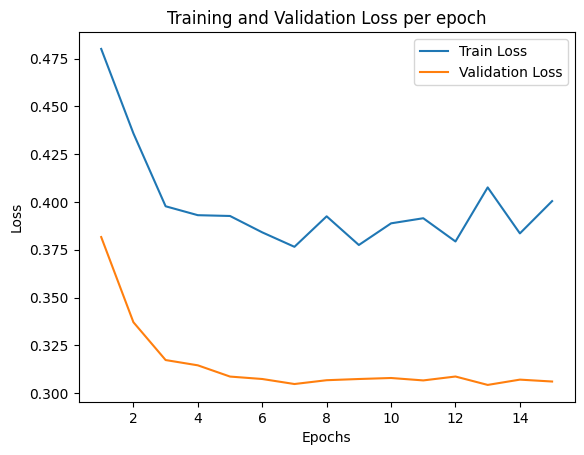

In [15]:
print('Start training ... ')
criterion = nn.CrossEntropyLoss().to(device)
train_val_loss = run_training(model=model, criterion=criterion, num_epochs=15, batch_size=batch_size, lr=1e-4, 
             check_after=1, train_loader=train_loader, val_loader=val_loader)